In [1]:
import glob
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt

In [2]:
not_wanted = set(["Greater", "Equal", "Pre", "Post", "Extrinsic-Pre", "Extrinsic-Post", "Assign", "Less", "OperationName", "Comparison"])

In [3]:
# This function builds a dictionary with all the words in the ann file as values and indices as their 
# corresponding variable names

def builddict(file):
    d = {}
    f = open(file, 'r')
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        if line.startswith("T"):
                line = line.split("\t")[1:]
                entity = line[0].split(" ")[0]
                if entity not in not_wanted:
                    _, si, ei = line[0].split(" ")
                    if si not in d:
                        d[si] = []
                        d[si].append(str(entity)) 
                        d[si].append(str(line[1]))
    return d

In [4]:
# This function builds a listt of list for a given txt file, with the entries of the inner list being
# the words in the txt file and its corresponding tag (var/value)

def build_dataframe(file, d):
    df = []
    with open(file) as f:
        cindex = 0
        seen = False
        end = 0
        nonzerocount = 0
        temp = f.readlines()
        flag = False
        
        for line in temp:
            tempstr = ""
            
            if "DESCRIPTION" in line:
                flag = True
            for i,char in enumerate(line):
                i_inner = end+i
                if str(cindex) in d or seen and flag:
                    seen = True
                    tempstr += char
                    
                    if seen and str(cindex) in d and i_inner == cindex+int(len(d[str(cindex)][1])):
                        seen = False
                        # add to df
                        # check if var or val 
                        if d[str(cindex)][0] != "Value":
#                             df.append([tempstr[:-1], d[str(cindex)][0]])
                            df.append([tempstr[:-1], "Variable"])
                        else:
                            df.append([tempstr[:-1], d[str(cindex)][0]])
                        tempstr = ""
                        cindex = i_inner
                        nonzerocount += 1

                else:
                    if flag:
                        if char == " ":
                            df.append([tempstr, '0'])
                            tempstr = ""
                        else:
                            tempstr += char

                    cindex = i_inner

            end += len(line)
    return df,nonzerocount

In [5]:
# This cell generates the training data per file and appends to the data list

import os
from collections import defaultdict

EXTENSIONS = {'.ann', '.txt'}

# directory = 'only ann'
directory = './Annotated files/'

grouped_files = defaultdict(int)

for f in os.listdir(directory):
    name, ext = os.path.splitext(os.path.join(directory, f))
    if ext in EXTENSIONS:
        grouped_files[name] += 1
data = []
totalcount = 0
tc2 = 0
for name in grouped_files:
    if grouped_files[name] == len(EXTENSIONS):
        filetxt = '{}.txt'.format(name)
        fileann = '{}.ann'.format(name)
#         print "*"*10,filetxt,fileann
        d = builddict(fileann)
        totalcount += len(d)
        df,nzc = build_dataframe(filetxt, d)
        tc2 += nzc
        data += df

In [6]:
# Converting the data list to pandas dataframe
dataframe = pd.DataFrame(data, columns=['entity', 'tag'])

In [7]:
# Run this cell to get rid of empty entries
dataframe['entity'].replace('', np.nan, inplace=True)
dataframe.dropna(inplace=True)

In [23]:
vvData = dataframe[dataframe['tag']!='0'] 

In [24]:
# Writing train data to file
dataframe.to_csv("train_data.csv")

In [8]:
dataframe.head()

,entity,tag
0,16.22.4.,0
2,PUTROOTFH,0
3,replaces,0
4,the,0
5,current filehandle,Variable


In [29]:
dataframe[dataframe['tag']!='0']

,entity,tag
5,current filehandle,Variable
8,filehandle that represents the root of the ser...,Variable
100,client identifier,Variable
102,callback,Variable
105,callback_ident,Variable
265,callback_ident,Variable
282,callback_ident,Variable
1275,attributes,Variable
1280,NFS4ERR_SAME,Value
1284,<NULL>,Value


In [9]:
df2 = []
sentence_id = 0

import re
import nltk

for index, row in dataframe.iterrows():
    for ele in row['entity'].split(" "):
#         s = re.sub(r'[^\w\s]','',ele)
        ele = re.sub('[(){},]', '', ele)
        ele2 = ele = re.sub('[(){},<>]', '', ele)
        token = nltk.word_tokenize(ele2)
        pos_tag = nltk.pos_tag(token)
        if pos_tag:
            pos_tag = pos_tag[0][1]
        else:
            pos_tag = "."
        df2.append([ele, row['tag'], sentence_id, pos_tag])
        if "<NULL>" in ele:
            sentence_id += 1
df2 = pd.DataFrame(df2, columns=['entity', 'tag', 'Sentence #', 'POS'])
df2.to_csv("train_data_3.csv")

In [10]:
df2 = df2.iloc[1:]
df2.head()

,entity,tag,Sentence #,POS
1,PUTROOTFH,0,0,NN
2,replaces,0,0,NNS
3,the,0,0,DT
4,current,Variable,0,JJ
5,filehandle,Variable,0,NN


{'Variable': 630, '0': 18492, 'Value': 309}


([<matplotlib.axis.XTick at 0x7f6a93dd1210>,
 <a list of 3 Text xticklabel objects>)

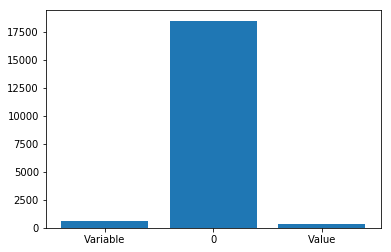

In [47]:
# Some analysis
dtag = {}
for index, row in df2.iterrows():
    if row['tag'] not in dtag:
        dtag[row['tag']] = 0
    dtag[row['tag']] += 1
print dtag
plt.bar(range(len(dtag)), list(dtag.values()), align='center')
plt.xticks(range(len(dtag)), list(dtag.keys()))

In [48]:
vvData = df2[df2['tag']!='0'] 

### CountVectorizer model on full data

In [55]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(["Variable", "Value"])

vvData.head()
#X = vvData['entity']
#Y = le.transform(vvData['tag'])
#Y = vvData['tag']

X = dataframe['entity']
Y = dataframe['tag']


from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, Y_train)
#print(clf.predict(count_vect.transform(["current filehandle"])))

# pred = clf.predict(count_vect.transform(X_test))
# for p in pred:
#     if p != pred[0]:
#         print(p)


print('Accuracy of NB classifier on training set: {:.2f}'
     .format(clf.score(X_train_tfidf, Y_train)))
print('Accuracy of NB classifier on test set: {:.2f}\n'
     .format(clf.score(count_vect.transform(X_test), Y_test)))

pred = clf.predict(count_vect.transform(X_test))
print(classification_report(Y_test, pred, target_names=['0','Value','Variable']))

print("==================================================================")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


LSVC = LinearSVC()
LSVC.fit(X_train_tfidf, Y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(LSVC.score(X_train_tfidf, Y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}\n'
     .format(LSVC.score(count_vect.transform(X_test), Y_test)))

pred = LSVC.predict(count_vect.transform(X_test))
print(classification_report(Y_test, pred, target_names=['0','Value','Variable']))

print("==================================================================")


logreg = LogisticRegression()
logreg.fit(X_train_tfidf, Y_train)

print('Accuracy of Log Reg classifier on training set: {:.2f}'
     .format(logreg.score(X_train_tfidf, Y_train)))
print('Accuracy of Log Reg classifier on test set: {:.2f}\n'
     .format(logreg.score(count_vect.transform(X_test), Y_test)))

pred = logreg.predict(count_vect.transform(X_test))
print(classification_report(Y_test, pred, target_names=['0','Value','Variable']))

print("==================================================================")

rForest = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
rForest.fit(X_train_tfidf, Y_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rForest.score(X_train_tfidf, Y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(rForest.score(count_vect.transform(X_test), Y_test)))

pred = rForest.predict(count_vect.transform(X_test))
print(classification_report(Y_test, pred, target_names=['0','Value','Variable']))

print("==================================================================")

Accuracy of NB classifier on training set: 0.97
Accuracy of NB classifier on test set: 0.96

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4606
       Value       0.00      0.00      0.00        50
    Variable       1.00      0.09      0.16       129

   micro avg       0.96      0.96      0.96      4785
   macro avg       0.65      0.36      0.38      4785
weighted avg       0.96      0.96      0.95      4785

Accuracy of SVM classifier on training set: 0.98
Accuracy of SVM classifier on test set: 0.97

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4606
       Value       0.71      0.34      0.46        50
    Variable       0.83      0.38      0.52       129

   micro avg       0.97      0.97      0.97      4785
   macro avg       0.84      0.57      0.66      4785
weighted avg       0.97      0.97      0.97      4785

Accuracy of Log Reg classifier on training set: 0.

In [72]:
# Testing the SVM model on sentences
example_sent = "The saved filehandle must be returned on success <NULL>.".split(" ")
# print example_sent
ids = np.arange(len(example_sent))
temp = pd.DataFrame(example_sent, ids)
preds = LSVC.predict(count_vect.transform(example_sent))
print zip(preds,example_sent)

[('0', 'The'), ('0', 'saved'), ('0', 'filehandle'), ('0', 'must'), ('0', 'be'), ('0', 'returned'), ('0', 'on'), ('Value', 'success'), ('0', '<NULL>.')]


## Context Based model on full data

In [15]:
df2.head()

,entity,tag,Sentence #,POS
1,PUTROOTFH,0,0,NN
2,replaces,0,0,NNS
3,the,0,0,DT
4,current,Variable,0,JJ
5,filehandle,Variable,0,NN


In [16]:
# Collecting contexts for training instances

def collect_context(df2):
    window_len = 3

    entity, tag = [], []

    x_train = []
    y_train = []

    for index, row in df2.iterrows():
        entity.append(row['entity'])
        tag.append(row['tag'])
    
    for i in range(1, len(entity)):
        temp_str = ""
        for j in range(window_len):
            if j + i <= len(entity):
                temp_str += entity[j+i-1]
                temp_str += " "
    
        
        x_train.append(temp_str)
        y_train.append(tag[i])
        
    return x_train, y_train
                
x_train, y_train = collect_context(df2)       

In [17]:
print len(x_train), len(y_train)

19430 19430


#### Preprocessing for getting embeddings

In [18]:
def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [45]:
# Get ids of words

def get_emb_features(x, y, mode='avg'):

    id2word = load_obj("../generate-glove/obj/id2word.pkl")
    word2id = {v: k for k, v in id2word.iteritems()}
    W = np.load("../generate-glove/obj/embeddings.npy")

    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')

#     x_train2 = []
    x_train2 = np.array([]).reshape(0,10)
    y_train2 = []
    

    # Get word vectors of those ids
    for sentence, tag in zip(x, y):
        
        sentence = sentence.strip()
        temp = tokenizer.tokenize(sentence)
        avg_vec = 0.0
        temp_vec = []
        len = 0
        for word in temp:

            # Check if word not in dict
            if word not in word2id:
                continue

            # Get id
            id = word2id[word]

            # Get vector
            vec = W[id]
            len += 1

            if mode == 'avg':
                # Avg
                avg_vec += vec
            elif mode == "append":
#                 temp_vec.append(vec)
                vec = np.array(vec).reshape(1,-1)
                x_train2 = np.concatenate((x_train2, vec))
                y_train2.append(tag)
            
        if len == 0:
            continue
        
        if mode == 'avg':
            avg_vec = 1.0*avg_vec/len
            avg_vec = np.array(avg_vec).reshape(1,-1)
            x_train2 = np.concatenate((x_train2, avg_vec))
#             x_train2.append(avg_vec)
            y_train2.append(tag)
            
#         elif mode == 'append':
#             x_train2.append(np.array(temp_vec))
#             y_train2.append(tag)
    
    return np.array(x_train2), np.array(y_train2)

#### Average word embeddings mehod

In [46]:
# SVM
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(["Variable", "Value"])

from sklearn.model_selection import train_test_split

# Get xtrain ytrain emb feats

x_train2, y_train2 = get_emb_features(x_train, y_train, mode='avg')
print x_train2.shape, y_train2.shape

X_train, X_test, Y_train, Y_test = train_test_split(x_train2, y_train2, random_state=0)

from sklearn.svm import LinearSVC
LSVC = LinearSVC()
LSVC.fit(X_train, Y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(LSVC.score(X_train, Y_train)))


print('Accuracy of SVM classifier on test set: {:.2f}\n'
     .format(LSVC.score(X_test, Y_test)))

pred = LSVC.predict(X_test)
print(classification_report(Y_test, pred, target_names=['0','Value','Variable']))



(19421, 10) (19421,)
Accuracy of SVM classifier on training set: 0.95
Accuracy of SVM classifier on test set: 0.95

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4608
       Value       0.00      0.00      0.00        90
    Variable       0.00      0.00      0.00       158

   micro avg       0.95      0.95      0.95      4856
   macro avg       0.32      0.33      0.32      4856
weighted avg       0.90      0.95      0.92      4856



#### Append word embeddings method

In [42]:
# SVM
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(["Variable", "Value"])

from sklearn.model_selection import train_test_split

# Get xtrain ytrain emb feats

x_train2, y_train2 = get_emb_features(x_train, y_train, mode='append')
print x_train2.shape, y_train2.shape

X_train, X_test, Y_train, Y_test = train_test_split(x_train2, y_train2, random_state=0)

from sklearn.svm import LinearSVC
LSVC = LinearSVC()
LSVC.fit(X_train, Y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(LSVC.score(X_train, Y_train)))


print('Accuracy of SVM classifier on test set: {:.2f}\n'
     .format(LSVC.score(X_test, Y_test)))

pred = LSVC.predict(X_test)
print(classification_report(Y_test, pred, target_names=['0','Value','Variable']))



(58889, 10) (58889,)
Accuracy of SVM classifier on training set: 0.95
Accuracy of SVM classifier on test set: 0.95

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13971
       Value       0.00      0.00      0.00       246
    Variable       0.00      0.00      0.00       506

   micro avg       0.95      0.95      0.95     14723
   macro avg       0.32      0.33      0.32     14723
weighted avg       0.90      0.95      0.92     14723

